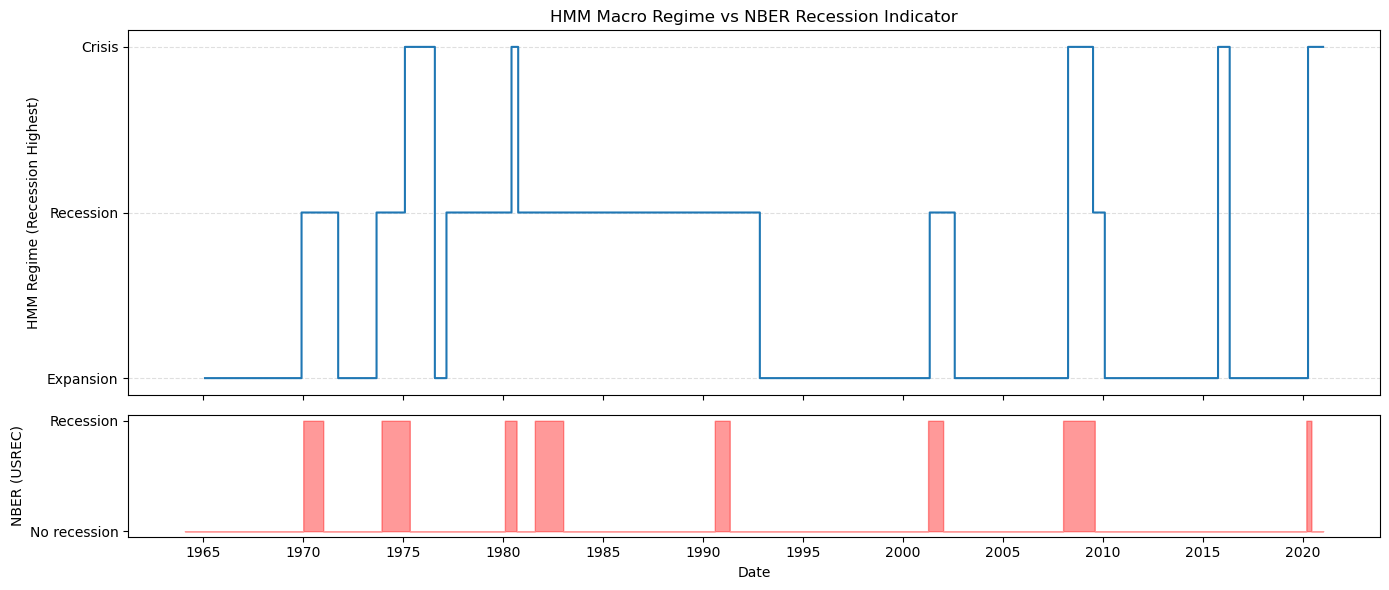

In [26]:
import os
import requests
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# -------------------- USER SETTINGS --------------------
os.environ["FRED_API_KEY"] = "0edd0176511cb5f2acbd2333dcbe28b1"
FRED_API_KEY = os.getenv("FRED_API_KEY", "YOUR_FRED_API_KEY_HERE")
START = "1964-01-01"
END   = "2020-12-31"


SERIES_IDS = [
    "GS10",      # 10-Year Treasury Constant Maturity Rate (%)
    "TB3MS",     # 3-Month Treasury Bill Rate (%)
    "BAA",       # Moody's Seasoned Baa Corporate Bond Yield (%)
    "AAA",       # Moody's Seasoned Aaa Corporate Bond Yield (%)
    "FEDFUNDS",  # Effective Federal Funds Rate (%)
    "INDPRO",    # Industrial Production Index
    "UNRATE",    # Unemployment Rate (%)
    "CPIAUCSL",  # CPI All Urban Consumers (SA)
    "USRECM", # data from fred regarding the inflation
]
FRED_BASE = "https://api.stlouisfed.org/fred/series/observations"
def fetch_fred_series(series_id, start=START, end=END):
    """Fetch one FRED series as a monthly Series indexed at month-end."""
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start,
        "observation_end": end,
    }
    r = requests.get(FRED_BASE, params=params, timeout=30)
    r.raise_for_status()
    obs = r.json()["observations"]
    df = pd.DataFrame(obs, columns=["date", "value"])

    # values: FRED uses "." for missing
    s = pd.to_numeric(df["value"].replace(".", np.nan), errors="coerce")

    # index at calendar month-end (avoids the Series.to_period issue)
    idx = pd.to_datetime(df["date"]) + pd.offsets.MonthEnd(0)
    s.index = idx
    s.name = series_id
    return s.sort_index()

def get_fred_dataframe(series_ids=SERIES_IDS, start=START, end=END):
    """Download all requested series into a single monthly DataFrame."""
    series_list = [fetch_fred_series(sid, start, end) for sid in series_ids]
    df = pd.concat(series_list, axis=1).sort_index()
    df = df[(df.index >= pd.Timestamp(start)) & (df.index <= pd.Timestamp(end))]
    return df.dropna(how="all")

# ---- run ----
fred_df = get_fred_dataframe()


df= fred_df.copy()
df["TERM_SPREAD"]   = df["GS10"] - df["TB3MS"]
df["CREDIT_SPREAD"] = df["BAA"]  - df["AAA"]

df["INDPRO_YoY"] = np.log(df["INDPRO"]).diff(12)*100
df["CPI_YoY"]    = np.log(df["CPIAUCSL"]).diff(12)*100
df["UNRATE_6m"]  = df["UNRATE"].diff(6)


feature_cols = [
        "INDPRO_YoY",
        "CPI_YoY",
        "UNRATE_6m",
        "TERM_SPREAD",
        "CREDIT_SPREAD",
        "FEDFUNDS"
    ]

df_feat = df[feature_cols].dropna()
X = df_feat.values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from hmmlearn.hmm import GaussianHMM

n_states = 3  # or 3
model = GaussianHMM(
    n_components=n_states,
    covariance_type="full",
    n_iter=200,
    random_state=42
)
model.fit(X_scaled)

# Smoothed probabilities (for conditional pricing)
probs = model.predict_proba(X_scaled)  # T x n_states
states = model.predict(X_scaled)       # Viterbi path (hard labels)

df_feat["state"] = states
for k in range(n_states):
    df_feat[f"p_state_{k}"] = probs[:, k]



label_map = {
    0: "Recession",
    1: "Crisis",
    2: "Expansion",
}
df_feat["regime_label"] = df_feat["state"].map(label_map)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------------------------------------
# 1. Remap states so recession is highest, expansion lowest
# ---------------------------------------------------------
# Original interpretation:
# 0 = Tight policy / high inflation
# 1 = Recession / crisis
# 2 = Expansion

state_remap = {1: 2, 0: 1, 2: 0}
df_feat["state_plot"] = df_feat["state"].map(state_remap)

# Remap label map accordingly
label_map_plot = {
    state_remap[k]: v for k, v in label_map.items()
}

# ---------------------------------------------------------
# 2. Plotting
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14, 6), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

# --------------------------
# TOP PANEL: HMM regimes
# --------------------------
ax1.step(df_feat.index, df_feat["state_plot"], where="post")

state_order_plot = sorted(df_feat["state_plot"].unique())
ax1.set_yticks(state_order_plot)
ax1.set_yticklabels([label_map_plot[s] for s in state_order_plot])

ax1.set_title("HMM Macro Regime vs NBER Recession Indicator")
ax1.set_ylabel("HMM Regime (Recession Highest)")
ax1.grid(True, axis="y", linestyle="--", alpha=0.4)

# --------------------------
# BOTTOM PANEL: NBER recessions (USREC = 0/1)
# --------------------------
ax2.fill_between(
    df.index,
    0,
    df["USRECM"].fillna(0),
    step="post",
    alpha=0.4,
    color="red",
)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["No recession", "Recession"])
ax2.set_ylabel("NBER (USREC)")

# X-axis formatting
ax2.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

In [27]:
# Boolean masks for each regime
is_recession = df_feat["regime_label"] == "Recession"
is_crisis    = df_feat["regime_label"] == "Crisis"
is_expansion = df_feat["regime_label"] == "Expansion"

# 1) As 'YYYY-MM' strings (unique months)
recession_months = df_feat.index[is_recession].strftime("%Y-%m").unique()
crisis_months    = df_feat.index[is_crisis].strftime("%Y-%m").unique()
expansion_months = df_feat.index[is_expansion].strftime("%Y-%m").unique()



In [28]:
main_df = pd.read_csv("data/Stock level signals.csv")
main_df["date"] = pd.to_datetime(main_df["date"], format="%m/%Y")

In [29]:
recession_df = main_df[main_df['date'].isin(recession_months)]
crisis_df    = main_df[main_df['date'].isin(crisis_months)]
expansion_df = main_df[main_df['date'].isin(expansion_months)]

# change date back to this form "%m/%Y"
recession_df["date"] = recession_df["date"].dt.strftime("%m/%Y")
crisis_df["date"]    = crisis_df["date"].dt.strftime("%m/%Y")
expansion_df["date"] = expansion_df["date"].dt.strftime("%m/%Y")

recession_df.to_csv("data/recession_stock_signals.csv", index=False)
crisis_df.to_csv("data/crisis_stock_signals.csv", index=False)
expansion_df.to_csv("data/expansion_stock_signals.csv", index=False)